# Students Performance
Dataset used: [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance)

Target Variable:
- G3: integer final grade



Notes, Todos 
- Mat vs Portuguese -> Instances jeweils selbe Person, also hat eine gewisse Kombination von Attributen 2 verschiedene Ground Truths (Mathe und Portug.)
- Target G3: was machen mit G1, G2. Prediction mit G1,G2 wsl gut, aber macht andere Attribute weniger relevant -> raushauen


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
# Read data from file
mat = pd.read_csv("../data/students/student-mat.csv", sep=";") # mathematics
por = pd.read_csv("../data/students/student-por.csv", sep=";") # portuguese
# frames = [mat, por]
# df = pd.concat(frames)
df = por
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [4]:
# show attributes, types and number of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

# Missing Values

In [5]:
# all rows with nan values, 0 in total
null_students = df[df.isnull().values.any(axis=1)]
null_students.shape

# how many values missing per column, only if > 0
values_missing = df.isna().sum()
values_missing[values_missing > 0]

# percentage for each column
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing[percent_missing > 0]

# how many values missing in total, 0 in total
df.isnull().sum().sum()
# how many values missing per column
df.isnull().sum()
print("No missing values")

No missing values


# Correlation

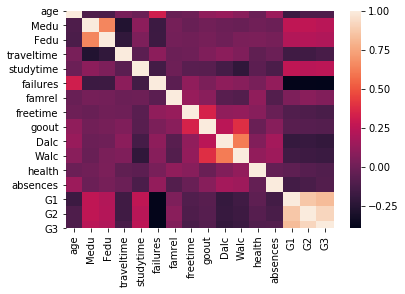

In [6]:
# heatmap visualises the correlation of each pair of values
sns.heatmap(df.corr())

"G3 has a strong correlation with attributes G2 and G1. 
This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. 
It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details)." (https://archive.ics.uci.edu/ml/datasets/Student+Performance)

Therefore we decide to eliminate G1 & G2

In [7]:
#df = df.drop(columns=["G1", "G2"])

Additionally there can be seen that the attributes Medu-Fedu, Dalc-Walc, goout-Walc, goout-freetime correlate. Concerning the target variable G3, there is a slight negative correlation with the amount of failures. Other significant variables seem to be Medu, studytime, Fedu, Dalc, age, Walc (this order)

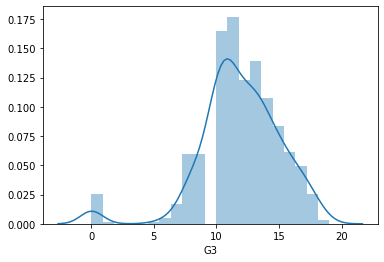

In [8]:
# Distribution of the target variable
np.median(df.G3)
sns.distplot(df.G3)

# Preprocessing

In [9]:
df['school'] = [0 if x == 'GP' else 1 if x == 'MS' else 2 for x in df['school']]

In [10]:
df['sex'] = [0 if x == 'F' else 1 if x == 'M' else 2 for x in df['sex']]

In [11]:
df['address'] = [0 if x == 'U' else 1 if x == 'R' else 2 for x in df['address']]

In [12]:
df['famsize'] = [0 if x == 'GT3' else 1 if x == 'LE3' else 2 for x in df['famsize']]

In [13]:
df['Pstatus'] = [0 if x == 'T' else 1 if x == 'A' else 2 for x in df['Pstatus']]

In [14]:
dummies = pd.get_dummies(df['Mjob'], prefix='Mjob')
df = pd.concat([df, dummies], axis=1)
df = df.drop('Mjob',1)

In [15]:
dummies = pd.get_dummies(df['Fjob'], prefix='Fjob')
df = pd.concat([df, dummies], axis=1)
df = df.drop('Fjob',1)

In [16]:
dummies = pd.get_dummies(df['reason'], prefix='reason')
df = pd.concat([df, dummies], axis=1)
df = df.drop('reason',1)

In [17]:
dummies = pd.get_dummies(df['guardian'], prefix='guardian')
df = pd.concat([df, dummies], axis=1)
df = df.drop('guardian',1)

In [18]:
df['schoolsup'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['schoolsup']]

In [19]:
df['famsup'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['famsup']]

In [20]:
df['paid'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['paid']]

In [21]:
df['activities'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['activities']]

In [22]:
df['nursery'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['nursery']]

In [23]:
df['higher'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['higher']]

In [24]:
df['internet'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['internet']]

In [25]:
df['romantic'] = [0 if x == 'no' else 1 if x == 'yes' else 2 for x in df['romantic']]

In [26]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,0,0,1,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
1,0,0,17,0,0,0,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,0,15,0,1,0,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,0,0,15,0,0,0,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,0,0,16,0,0,0,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1,0,19,1,0,0,2,3,1,3,1,0,0,0,1,0,1,1,0,5,4,2,1,2,5,4,10,11,10,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
645,1,0,18,0,1,0,3,1,1,2,0,0,1,0,0,1,1,1,0,4,3,4,1,1,1,4,15,15,16,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
646,1,0,18,0,0,0,1,1,2,2,0,0,0,0,1,1,1,0,0,1,1,1,1,1,5,6,11,12,9,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
647,1,1,17,0,1,0,3,1,2,1,0,0,0,0,0,0,1,1,0,2,4,5,3,4,2,6,10,10,10,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


# Classification
Classifier: Random Forest, KNN, SVM

In [27]:
# Train & Test
train, test = train_test_split(df, test_size=0.2, random_state=44)

# Training Model
x_train = train.drop('G3', axis=1)
y_train = train['G3']

# Testing
x_test = test.drop('G3', axis=1)
y_test = test['G3']

In [28]:
# Scores: MSE, RMSE, R2
def print_performance(y_test, y_pred):
    # Mean Squared Error
    print("MSE: ", metrics.mean_squared_error(y_test,y_pred))
    
    print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
    
    # R2 is between 0 and 100 percent
    # 0 indicates that the model explains none of the variability of the response data around its mean.
    # 100 indicates that the model explains all the variability of the response data around its mean.
    print("R2: ", metrics.r2_score(y_test,y_pred) * 100)

# DEPRECATED: especially for linear regression
def print_scores(model, x_train, y_train):
    r_sq = model.score(x_train, y_train)
    b0 = model.intercept_
    b1 = model.coef_
    print("r_sq, coefficient of determination: ")
    print(r_sq)
    print("b0, intercept: ")
    print(b0)
    print("b1, slope: ")
    print(b1)
    
    print("y_pred = model.intercept_ + model.coef_ * x")

# Metrics: various fancy metrics
def print_metrics(y_test, y_pred):
    results = pd.DataFrame(list(zip(y_test, y_pred)), 
                   columns =['Wage_test', 'Wage_prediction']) 
    
    accuracy = results["Wage_test"] - results["Wage_prediction"]
    accuracy = np.square(accuracy)
    accuracy = np.sqrt(accuracy)
    
    print("# compare test and prediction")
    print(results)
    
    print("# bad predictions (over 100 difference)")
    print(results[(results["Wage_test"] - results["Wage_prediction"]) > 5])
    
    print("# span of data")
    span = results["Wage_test"].max() - results["Wage_test"].min()
    print(span)
    
    print("# median accuracy")
    median = np.median(accuracy) 
    print(median)
    
    print("# percent deviation")
    percent = median / span * 100
    percent_str = "{:.4f}".format(percent)
    percent_str = percent_str + " %"
    print(percent_str)
    return results

# Plot to visualise the quality of the predictions
def print_scatterplot(y_test, y_pred):
    # Plot outputs
    #plt.scatter(np.log(y_test), np.log(y_pred))
    plt.scatter(y_test, y_pred)
    
    plt.xlabel("Grade_test")
    plt.ylabel("Grade_prediction")
    
    # plt.xlim(-1, 500)
    # plt.ylim(-1, 500)
    
    # plt.xticks(())
    # plt.yticks(())
    
    plt.show()

In [29]:
# Random Forest
# params
forest_n_estimators = [10, 50, 75]
forest_max_depth = [6, 9, 12, 15, 20]
forest_min_split = [2, 5] 

grid = GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': forest_n_estimators,
                         'max_depth': forest_max_depth,
                         'min_samples_leaf': forest_min_split})
grid.fit(x_train, y_train)

print(grid.best_params_)
y_pred_1 = grid.predict(x_test)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 10}


MSE:  2.0350529281038314
RMSE:  1.42655281293888
R2:  77.85265248346325
# compare test and prediction
     Wage_test  Wage_prediction
0           17        14.875000
1           11        11.173810
2           12        11.106986
3           13        13.544048
4           13        12.985521
..         ...              ...
125         12        12.896701
126         11        11.418860
127         12        13.527251
128         15        14.666667
129         12        10.931105

[130 rows x 2 columns]
# bad predictions (over 100 difference)
    Wage_test  Wage_prediction
25          8         2.491667
67         16         9.864104
# span of data
17
# median accuracy
0.5879953379953378
# percent deviation
3.4588 %


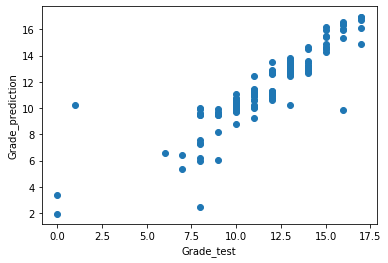

In [30]:
print_performance(y_test, y_pred_1)
print_metrics(y_test, y_pred_1)
print_scatterplot(y_test, y_pred_1)

In [31]:
# KNN
# params
n_neighbour = [2, 5, 8, 12] 
weights = ['uniform', 'distance']

grid = GridSearchCV(estimator=neighbors.KNeighborsRegressor(),
             param_grid={'n_neighbors': n_neighbour,
                        'weights': weights})
grid.fit(x_train, y_train)

print(grid.best_params_)
y_pred_2 = grid.predict(x_test)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 8, 'weights': 'distance'}


MSE:  2.351740002490005
RMSE:  1.5335383928972908
R2:  74.40616782767545
# compare test and prediction
     Wage_test  Wage_prediction
0           17        15.093657
1           11        11.104856
2           12        11.409668
3           13        13.109849
4           13        14.125539
..         ...              ...
125         12        12.136083
126         11        12.277774
127         12        12.845941
128         15        13.877506
129         12        11.875322

[130 rows x 2 columns]
# bad predictions (over 100 difference)
    Wage_test  Wage_prediction
67         16        10.703405
# span of data
17
# median accuracy
0.6072000760207255
# percent deviation
3.5718 %


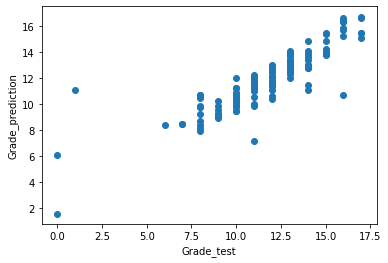

In [32]:
print_performance(y_test, y_pred_2)
print_metrics(y_test, y_pred_2)
print_scatterplot(y_test, y_pred_2)

In [33]:
# SVM



MSE:  2.351740002490005
RMSE:  1.5335383928972908
R2:  74.40616782767545
# compare test and prediction
     Wage_test  Wage_prediction
0           17        15.093657
1           11        11.104856
2           12        11.409668
3           13        13.109849
4           13        14.125539
..         ...              ...
125         12        12.136083
126         11        12.277774
127         12        12.845941
128         15        13.877506
129         12        11.875322

[130 rows x 2 columns]
# bad predictions (over 100 difference)
    Wage_test  Wage_prediction
67         16        10.703405
# span of data
17
# median accuracy
0.6072000760207255
# percent deviation
3.5718 %


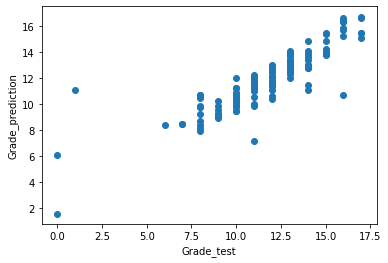

In [34]:
print_performance(y_test, y_pred_2)
print_metrics(y_test, y_pred_2)
print_scatterplot(y_test, y_pred_2)